## Question 1

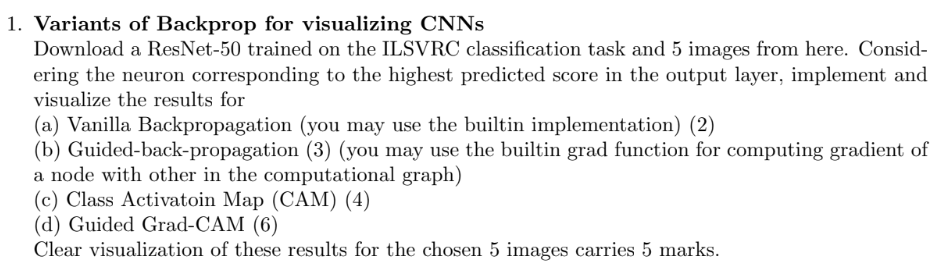

In [6]:
import torch
from torch import nn
import numpy as np
import os
import matplotlib.pyplot as plt
from torchvision import models, transforms
from torch.autograd import Variable
from PIL import Image
from torch.nn import ReLU
import io
from torch.nn import functional as F
import cv2

## Helper functions :-

In [7]:
def format_np_output(np_arr):
    """
    A function to convert any numpy array of the below form to 3xWxH
    Args:
        np_arr (Numpy array): Matrix of shape 1xWxH or WxH or 3xWxH
    """
    # Case 1: If only 1 channel (assuming first dim is channel) i.e grayscale image
    # Repeat first channel and convert 1xWxH to 3xWxH
    if np_arr.shape[0] == 1:
        np_arr = np.repeat(np_arr, 3, axis=0)
    # Case 2: If arr is of shape 3xWxH , convert it to WxHx3 (PIL saveble)
    if np_arr.shape[0] == 3:
        np_arr = np_arr.transpose(1, 2, 0)
    # Case 3: If np arr is normalized between 0-1,  multiply with 255 
    # Image.fromarray is poorly defined with floating-point input; it's not well documented but
    # the function assumes the input is laid-out as unsigned 8-bit integers.
    if np.max(np_arr) <= 1:
        np_arr = (np_arr*255).astype(np.uint8)                           
    return np_arr


def display_two_images(im1, im2, vis_method , gray = False):
    """
        Displays two PIL images side-by-side in a single subplot. 
    Args:
        im1: PIL image or Matrix of shape D x W x H 
        im2: PIL image or Matrix of shape D x W x H 
        vis_method : Visualisatioin method used
        gray: Boolean indicating if the images are to ploted as grayscale or not
    """
    if isinstance(im1, (np.ndarray, np.generic)):
        im1 = format_np_output(im1)
        im1 = Image.fromarray(im1)
    
    if isinstance(im1, (np.ndarray, np.generic)):
        im2 = format_np_output(im2)
        im2 = Image.fromarray(im2)
    
    fig, ax = plt.subplots(1, 2, figsize = (10, 5))
    
    ax[0].set_title('Original image')
    if gray:
        ax[0].imshow(im1, cmap='gray')
        ax[1].imshow(im2, cmap='gray') 
        ax[1].set_title(f'{vis_method} Saliency')
    else:
        ax[0].imshow(im1)
        ax[1].imshow(im2)
        ax[1].set_title(f'Colored {vis_method}')
    plt.show()

    
def preprocess_image(img):
    """
        Processes image for CNNs
    Args:
        img (PIL_img): PIL Image to be preprocessed
    returns:
        ima_as_var (torch variable): Processed float tensor
    """
    # Mean and std list for channels (Imagenet)   # Using the mean and std of Imagenet is a common practice. 
    # Since they are calculated based on millions of images and our data also kind of resembles that of ImageNet
    
    transform = transforms.Compose([            #[1]
     transforms.Resize(256),                    #[2]
     transforms.CenterCrop(224),                #[3]
     transforms.ToTensor(),                     #[4]
     transforms.Normalize(                      #[5]
     mean=[0.485, 0.456, 0.406],                #[6]
     std=[0.229, 0.224, 0.225]                  #[7]
     )])
       
    img_t = transform(img)
    batch_t = torch.unsqueeze(img_t, 0)    # Add one more channel to the beginning. Tensor shape = 1,3,224,224
    im_as_var = Variable(batch_t, requires_grad=True)  # convert to pytorch variable
    return im_as_var


def convert_to_grayscale(im_as_arr):
    """
        Converts 3d image to grayscale
    Args:
        im_as_arr (numpy arr): RGB image with shape (D,W,H)
    returns:
        grayscale_im (numpy_arr): Grayscale image with shape (1,W,D)
    """
    # Compute the average of the RGB channels
    gray = np.sum(np.abs(im_as_arr), axis=0)
    # Normalize the grayscale image
    im_max = np.percentile(gray, 99)
    im_min = np.min(gray)
    gray = ((gray - im_min)/ (im_max - im_min)).astype(np.float32)
    gray = (np.clip(gray, 0, 1))
    # Add channel dimension to the grayscale image
    gray = np.expand_dims(gray, axis=0)
    return gray


def get_gradient_image(gradient):
    """
        Gets the original gradient image
    Args:
        gradient (np arr): Numpy array of the gradient with shape (3, 224, 224)
    """
    # Normalize
    gradient = gradient - gradient.min()
    gradient /= gradient.max()

    return gradient
    

##  Define classes for the different Visualisation Techniques 
- Compatible with resnet50 model
- NOTE : A hook function is a function that is called every time the gradients flow backward through the layer it is registered to.

In [24]:
class VanillaBackprop():
    """
        Produces gradients generated with VBP from the image
    """
    def __init__(self, model):
        self.model = model
        self.model.eval()       
        self.gradients = None
        # Hook the first layer to get the gradient
        self.hook_first_layer()

    def hook_first_layer(self):
        def my_hook_fn(module, grad_in, grad_out):
            """   
                This hook function is used to extract the gradients of the first layer of the resnet 
            during backpropagation, which are later used in the vanilla backpropagation method 
            to visualize the important regions of the input image.  
                                                                     """
            
            self.gradients = grad_in[0]                          # sets the gradient inputs to the layer to self.gradients.
        
        # Find the first layer of the network and register a hook to it
        res50_conv = nn.Sequential(*list(self.model.children())[:-2])
        first_layer = res50_conv[0]
        first_layer.register_backward_hook(my_hook_fn)                     # registers a hook to the first_layer

        
    def generate_gradients(self, input_image, target_class):
        """
            Generates gradients using Vanilla backpropagation
            Args:
                input_image: Torch tensor of shape (1, 3, H, W) representing the input image
                target_class: Target class in ImageNet of the input image for which gradients are to be computed
            Returns:
                Gradients of the target class with respect to the input image as a numpy array of shape (3, H, W)
        """
        # Forward pass
        model_output = self.model(input_image)
        # set target class gradient to 1
        one_hot = torch.zeros((1, model_output.size()[-1]), dtype=torch.float32)
        one_hot[0][target_class] = 1
        one_hot = one_hot.to(input_image.device)   
        # Backward pass after zero gradient
        self.model.zero_grad()
        model_output.backward(gradient=one_hot)
        # Convert Pytorch variable to numpy array
        gradients_as_arr = self.gradients.data.numpy()[0]          # [0] is to get rid of the first channel in (1, 3, 224, 224)
        return gradients_as_arr

    
    
class GuidedBackprop():
    """
       Produces gradients generated with guided back propagation from the given image
    """
    def __init__(self, model):
        self.model = model
        self.model.eval()
        self.gradients = None
        self.update_relus()           
        self.hook_first_layer()

    def hook_first_layer(self):
        """
        Register a hook on the first layer to get the gradients of the input image
        """
        def my_hook_fn(module, grad_in, grad_out):
            self.gradients = grad_in[0]                  # sets the gradient inputs to the layer to self.gradients

        # Get the first layer of the resnet model and register the hook
        res50_conv = list(self.model.children())
        first_layer = res50_conv[0]
        first_layer.register_backward_hook(my_hook_fn)           # 

        
    def update_relus(self):
        """
            Updates relu activation functions to return only the positive gradients 
        """
        def my_relu_hook_fn(module, grad_in, grad_out):      # gradients w.r.t input and w.r.t. output
            """
            Accept only positive gradient , zero out all the negative ones
            """
            grad_in[0][grad_in[0] < 0] = 0
            return (grad_in[0]),
            
            
        # Loop through layers and if you find a ReLU layer, hook up ReLUs with my_relu_hook_function
        for module in self.model.modules():
            if isinstance(module, ReLU):
                module.register_backward_hook(my_relu_hook_fn)

                
    def generate_gradients(self, input_image, target_class):
        """
            Returns the gradients generated using guided backpropagation
            Args:
                input_image: Torch tensor of shape (1, 3, H, W) representing the input image
                target_class: Target class in ImageNet of the input image for which gradients are to be computed
            Returns:
                The guided gradients of the target class with respect to the input image as a numpy array of shape (3, H, W)
        """
        
        model_output = self.model(input_image)
        self.model.zero_grad()
        # set target class gradient to 1
        one_hot = torch.zeros((1, model_output.size()[-1]), dtype=torch.float32)
        one_hot[0][target_class] = 1
        one_hot = one_hot.to(input_image.device) 
        # Backward pass
        model_output.backward(gradient=one_hot)
        # Convert PyTorch tensor to numpy array and remove the first channel (1,3,224,224)
        guided_gradients_as_arr = self.gradients.data.numpy()[0]
        
        return guided_gradients_as_arr


    
class Class_Act_Map():  
    def __init__(self, model):
        self.model = model              # resnet already use global average pooling at the end, so CAM could be used directly.
        self.model.eval()
        self.finalconv_name = 'layer4'
        
    def predict_class(self, out, file_path):
        """ If there is a file containing the ImageNet labels and the corresponding class,
            this function can be called to predict the top prediction for the image.
            Here, out : model(preprocessed image) """
        
        # load the imagenet category list
        with open(file_path) as f:
            classes = [line.strip() for line in f.readlines()]
            
        _, indices = torch.sort(out, descending=True)                 # indices[0] is a tensor of predicted image labels in descending order
        percentage = torch.nn.functional.softmax(out, dim=1)[0] * 100
        print('The top1 prediction for the image using resnet50 model is : %s'%classes[indices[0][0]])
    
    
    def hook_final_conv_layer(self, batch_t):
        """
         Register a forward hook on the final_conv layer.
         """
        feature_blobs = []
        def my_hook_fn(module, input, output):
            feature_blobs.append(output.data.cpu().numpy())
        
        self.model._modules.get(self.finalconv_name).register_forward_hook(my_hook_fn) # Registers a global forward hook  
        out = self.model(batch_t)
        
        return feature_blobs

    def returnCAM(self, feature_blobs, idx):
        """ generates a class activation map (CAM) for a given image. weight_softmax is extracted from the model's parameters. 
            The weight_softmax corresponds to the weights of the final linear layer of the model.     
            Args : 
                 idx : target_idx for which the CAM is generated
                 feature_blobs : a list of feature maps for a given input image
                 
            """
        # get the softmax weight
        params = list(self.model.parameters())
        weight_softmax = np.squeeze(params[-2].data.numpy())
        
        # generate the class activation maps upsample to 256x256
        size_upsample = (256, 256)
        bz, nc, h, w = feature_blobs[0].shape
        output = []
        cam = weight_softmax[idx].dot(feature_blobs[0].reshape((nc, h*w)))
        cam = cam.reshape(h, w)
        cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam))  # Normalize between 0-1
        cam = np.uint8(cam * 255)                                # Scale between 0-255 to visualize
        output.append(cv2.resize(cam, size_upsample))
        
        return output
    
    

class GradCAM():  
    def __init__(self, model):
        self.model = model              # resnet already use global average pooling at the end, so CAM could be used directly.
        self.model.eval()
        self.gradients = None
        self.finalconv_name = 'layer4'
        self.feature_blobs = []
        self.hook_GAP_layer()

    def ReLU(self, x):
        """Relu activation function
        Args:
            x (float): array of inputs
        """
        return np.maximum(x, 0)        # apply element wise maximum

    def hook_final_conv_layer(self, batch_t):
        """
        Register a forward hook on the final conv layer to get the gradients of the input image
         """
        feature_blobs = []
        def my_hook_fn(module, input, output):
            feature_blobs.append(output.data.cpu().numpy())
        
        self.model._modules.get(self.finalconv_name).register_forward_hook(my_hook_fn)    # Registers a global forward hook  
        out = self.model(batch_t)

        return feature_blobs
    


    def hook_GAP_layer(self):
        def my_hook_fn(module, grad_in, grad_out):
            """   
                This hook function is used to extract the gradients of the GAP layer input 
                of the resnet during backpropagation.                                    
                                                                 """
            
            self.gradients = grad_in[0]                  # sets the gradient inputs to the layer to self.gradients.
        
        # Find the gap layer of the network and register a hook to it
        gap_layer = self.model.avgpool
        gap_layer.register_backward_hook(my_hook_fn)                     # registers a backward hook to the gap_layer


    def returngradCAM(self, input_image, feature_blobs, target_class):
        """ generates a Gradient weighted CAM for a given image. Instead of the softmax weights in 
            CAM, we use the gradients of the gap layer input and perform a GAP on it. 
        
            Args : 
                 idx : target_idx for which the CAM is generated
                 feature_blobs : a list of feature maps for a given input image
                 
            """
        # Forward pass
        model_output = self.model(input_image)
        # set target class gradient to 1
        one_hot = torch.zeros((1, model_output.size()[-1]), dtype=torch.float32)
        one_hot[0][target_class] = 1
        one_hot = one_hot.to(input_image.device)   
        # Backward pass after zero gradient
        self.model.zero_grad()
        model_output.backward(gradient=one_hot)
        # Pytorch variable 
        gradients_as_arr = self.gradients.data.numpy()[0]          # [0] is to get rid of the first channel in (1, 3, 224, 224)

        # Pool the gradients
        pooled_grad = np.mean(gradients_as_arr, (1,2))            # (2048, 7, 7) - > (2048)

        # generate the class activation maps upsample to 256x256
        size_upsample = (224, 224)
        bz, nc, h, w = feature_blobs[0].shape          # (1, 2048, 7, 7)
        output = []
        cam = pooled_grad.dot(feature_blobs[0].reshape((nc, h*w)))
        cam = cam.reshape(h, w)
        cam = self.ReLU(cam)
        cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam))  # Normalize between 0-1
        cam = np.uint8(cam * 255)                                # Scale between 0-255 to visualize
        output.append(cv2.resize(cam, size_upsample))   
        
        return output


class Guided_Grad_CAM():
    def get_guidedGradCAM(self, pretrained_model, prep_img, target_class):     
        
        # Instantiate the GuidedBackprop class and get gradients
        GBP = GuidedBackprop(pretrained_model)        
        GBP_grads = GBP.generate_gradients(prep_img, target_class)   
        
        # Instantiate the GradCAM class and get  Gradient weighted CAM for target class on input image
        GCAM = GradCAM(pretrained_model)
        feature_blobs = GCAM.hook_final_conv_layer(prep_img)
        GCAM_output = GCAM.returngradCAM(prep_img ,feature_blobs, target_class)

        # Combine guided backprop and gradCAM heatmaps to generate guided gradCAM heatmap
        GGCAM_output = GBP_grads * GCAM_output
        GGCAM_output = (GGCAM_output - np.min(GGCAM_output)) / (np.max(GGCAM_output) - np.min(GGCAM_output)) # normalise

        return GGCAM_output


### Defining a tuple of tuples where tup[0] has the image filename and tup[1] its corresponding ImageNet label
- Note: Download the images (jpg files) in the same directory as this python notebook

In [9]:
# Pick one of the examples, each examples are linked to their corresponding label as in ImageNet
example_list = (('i1.jpg', 235),         # hardcoded ImageNet label of the 'i1.jpg' 
                ('i2.jpg', 65),
                ('i3.jpg', 822),
                ('i4.jpg', 851),
                ('i5.jpg', 282))

## 1(a) Vanilla Backpropagation visualisation
-  Here, I have shown the output for 2 example images(1 to 2), feel free to change it to 5
    

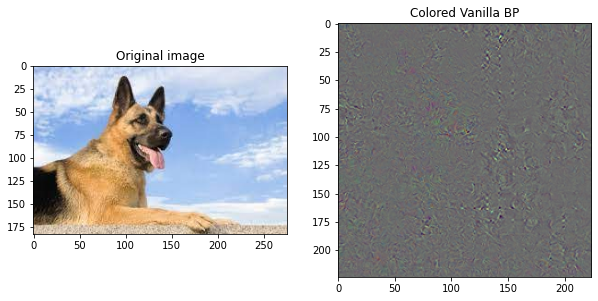

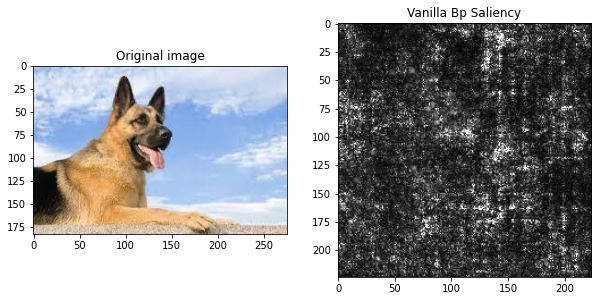

-------------------Vanilla backprop completed for image 0 ----------------------


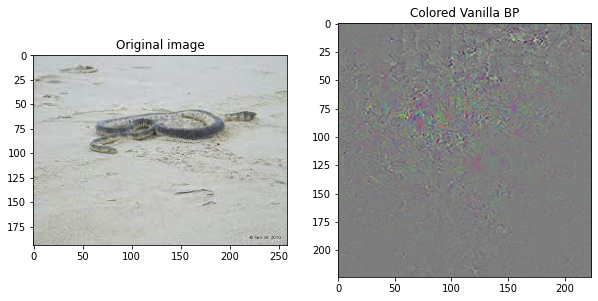

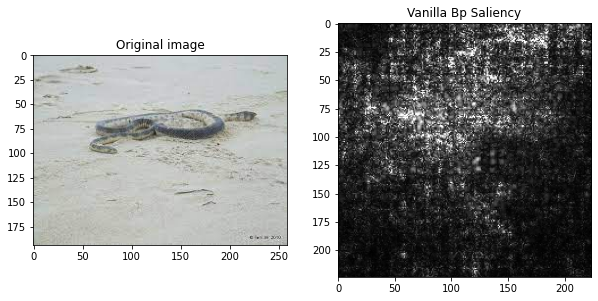

-------------------Vanilla backprop completed for image 1 ----------------------


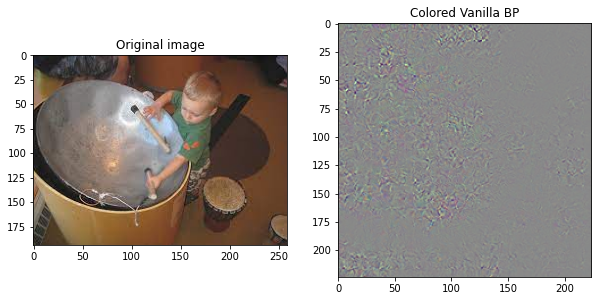

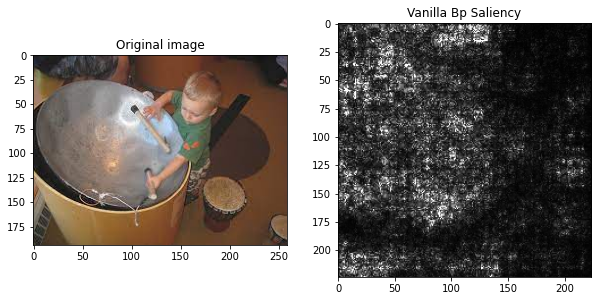

-------------------Vanilla backprop completed for image 2 ----------------------


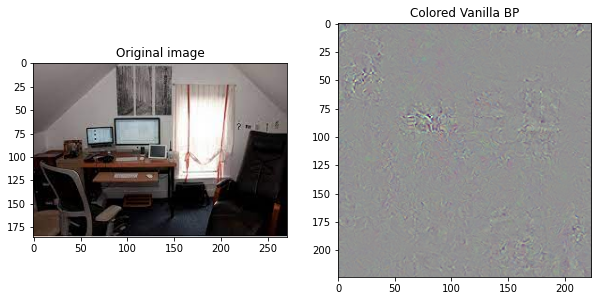

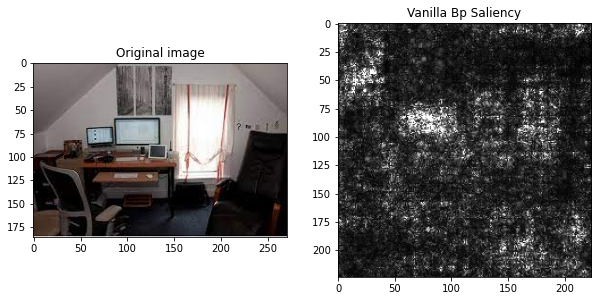

-------------------Vanilla backprop completed for image 3 ----------------------


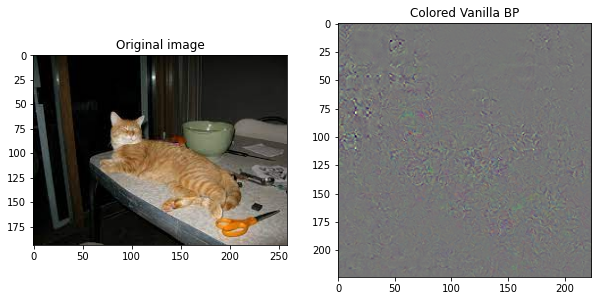

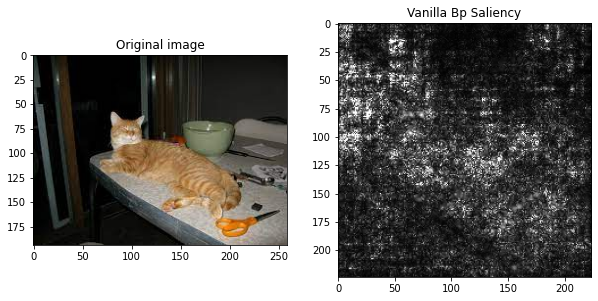

-------------------Vanilla backprop completed for image 4 ----------------------


In [41]:
no_of_examples_to_visualise = 5

for index in range(no_of_examples_to_visualise):
    # Image id to use from examples
    example_index = index                     # Image index 'i{index}.jpg'  

    img_path = example_list[example_index][0]
    target_class = example_list[example_index][1]      # Target class for the image

    # Read and preprocess image
    original_image = Image.open(img_path).convert('RGB')
    prep_img = preprocess_image(original_image)

    # Resnet model
    pretrained_model = models.resnet50(pretrained=True)

    # Vanilla backprop
    VBP = VanillaBackprop(pretrained_model)

    # Get gradients
    vanilla_grads = VBP.generate_gradients(prep_img, target_class)
    colored_gradient_img = get_gradient_image(vanilla_grads)
    display_two_images(original_image, np.transpose(colored_gradient_img, (1, 2, 0)), 'Vanilla BP') 

    # Convert to grayscale
    grayscale_vanilla_grads = convert_to_grayscale(vanilla_grads)
    grayscale_gradient_img = get_gradient_image(grayscale_vanilla_grads)
    display_two_images(original_image, np.transpose(grayscale_gradient_img, (1, 2, 0)),'Vanilla Bp', gray=True)

    print(f'-------------------Vanilla backprop completed for image {index} ----------------------')


## 1(b) Guided Backpropagation 
- Here, I have shown the output for 2 example images(1 to 2), feel free to change it to 5

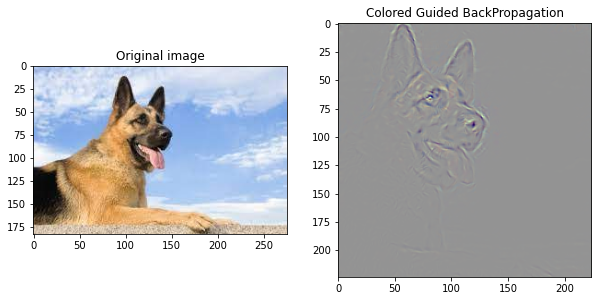

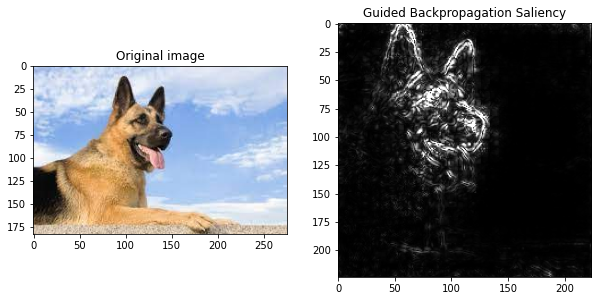

 -----------------  Guided backprop completed for image 0 ----------------------- 



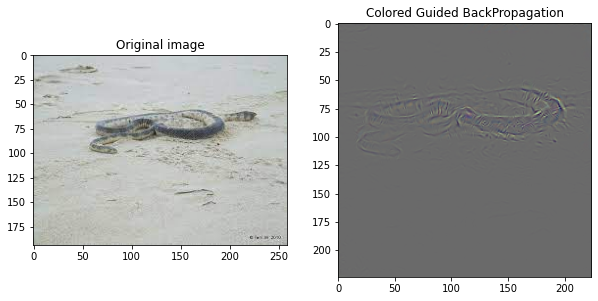

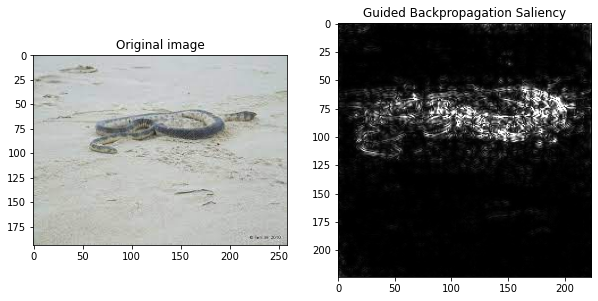

 -----------------  Guided backprop completed for image 1 ----------------------- 



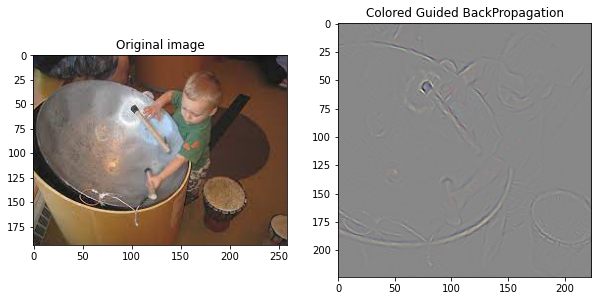

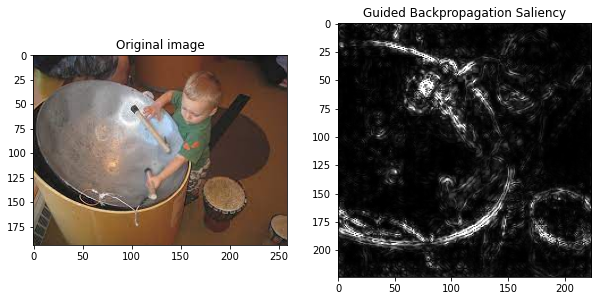

 -----------------  Guided backprop completed for image 2 ----------------------- 



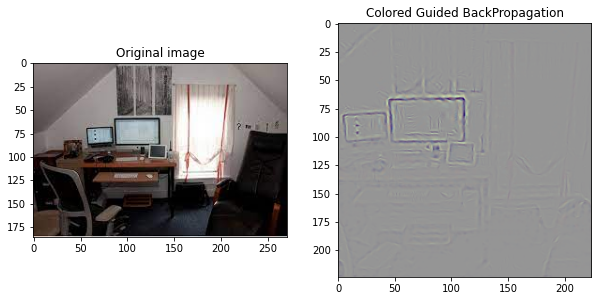

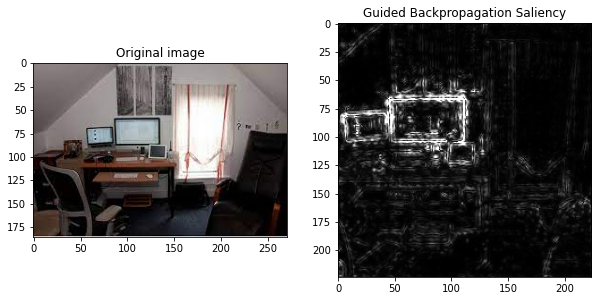

 -----------------  Guided backprop completed for image 3 ----------------------- 



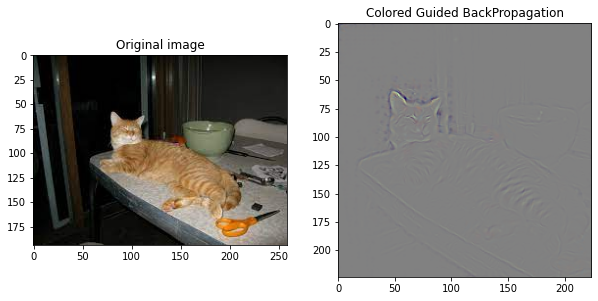

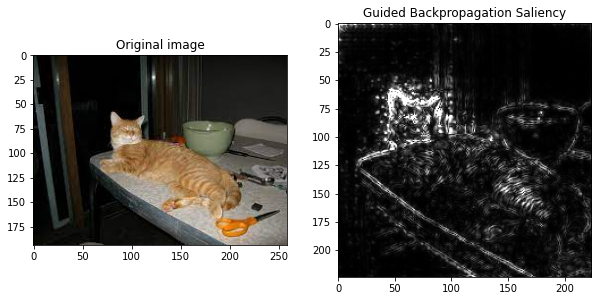

 -----------------  Guided backprop completed for image 4 ----------------------- 



In [42]:
no_of_examples_to_visualise = 5

for index in range(no_of_examples_to_visualise):   
    example_index = index        # Example "index"

    img_path = example_list[example_index][0]
    target_class = example_list[example_index][1]      # Target class for the image

    # Read image
    original_image = Image.open(img_path).convert('RGB')
    # Preprocess image
    prep_img = preprocess_image(original_image)

    # Guided backprop
    GBP = GuidedBackprop(pretrained_model)

    # Get the gradients
    GBP_grads = GBP.generate_gradients(prep_img, target_class)   # Gradient of the operation to visualize
    colored_GBP_gradient_img = get_gradient_image(GBP_grads)
    display_two_images(original_image, np.transpose(colored_GBP_gradient_img, (1, 2, 0)), 'Guided BackPropagation')

    # Convert to grayscale
    grayscale_GBP_grads = convert_to_grayscale(GBP_grads)
    grayscale_GBP_gradient_img = get_gradient_image(grayscale_GBP_grads)
    display_two_images(original_image, np.transpose(grayscale_GBP_gradient_img, (1, 2, 0)),'Guided Backpropagation', gray=True)


    print(f' -----------------  Guided backprop completed for image {index} ----------------------- \n')

## 1.(c) Class Activation Map (CAM)

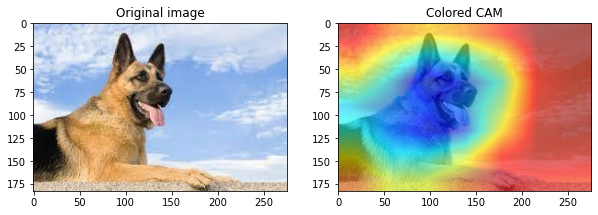

 -----------------------  CAM completed for image 0 -----------------------------



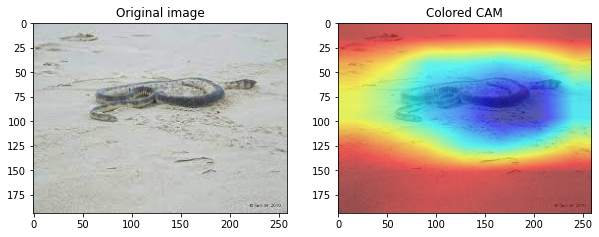

 -----------------------  CAM completed for image 1 -----------------------------



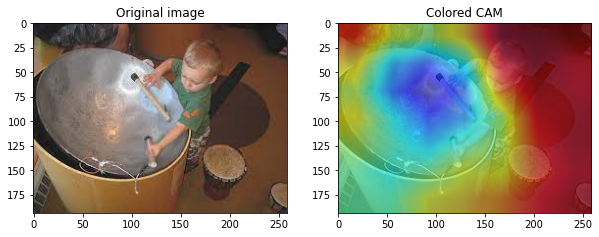

 -----------------------  CAM completed for image 2 -----------------------------



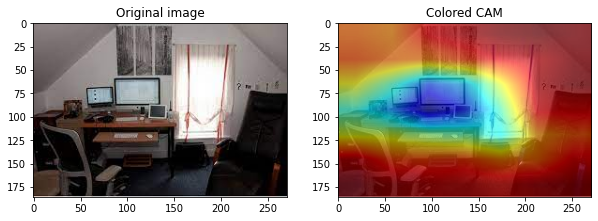

 -----------------------  CAM completed for image 3 -----------------------------



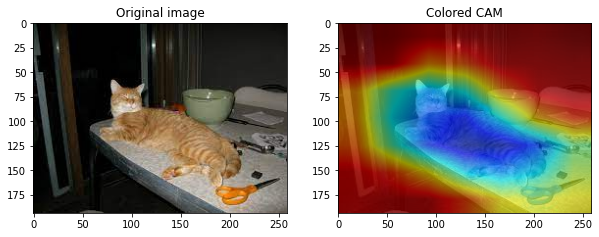

 -----------------------  CAM completed for image 4 -----------------------------



In [38]:
for index in range(5):
    example_index = index          # Example 1

    img_path = example_list[example_index][0]
    target_class = example_list[example_index][1]      # Target class for the image

    # Read and preprocess image
    original_image = Image.open(img_path).convert('RGB')
    prep_img = preprocess_image(original_image)         

    # Class Activation Map
    CAM = Class_Act_Map(pretrained_model)
    feature_blobs = CAM.hook_final_conv_layer(prep_img)


    # generate class activation mapping for the top prediction 
    CAM_output = CAM.returnCAM(feature_blobs, target_class)


    # render the CAM and output
    img = cv2.imread(img_path)
    h, w, _ = img.shape
    heatmap = cv2.applyColorMap(cv2.resize(CAM_output[0], (w, h)), cv2.COLORMAP_JET)
    result = heatmap * 0.7 + img * 0.5
    cv2.imwrite('CAM.jpg', result)


    result = result/np.amax(result)         # Normalise the result between 0 and 1 as it is float datatype
    display_two_images(original_image, result ,'CAM')
    print(f' -----------------------  CAM completed for image {index} -----------------------------\n')


## 1(d) Guided Grad-CAM

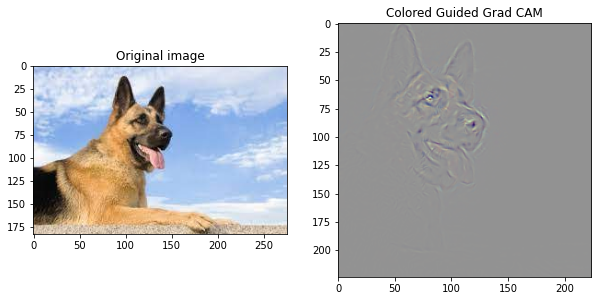

 -----------------  Guided GradCAM completed for image 0 ----------------------- 



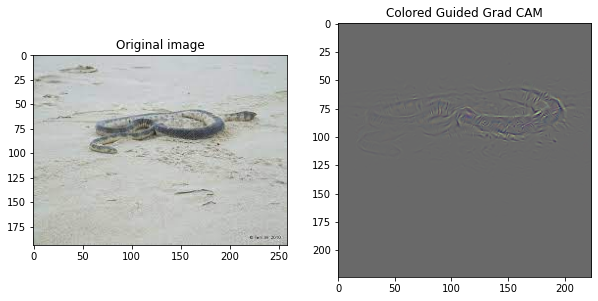

 -----------------  Guided GradCAM completed for image 1 ----------------------- 



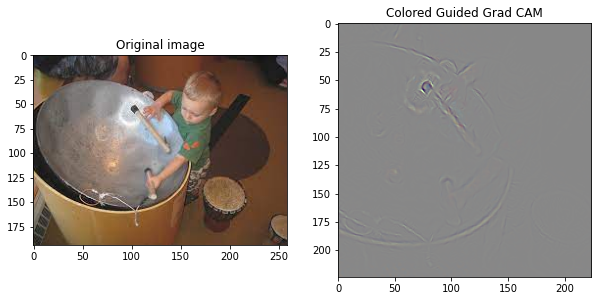

 -----------------  Guided GradCAM completed for image 2 ----------------------- 



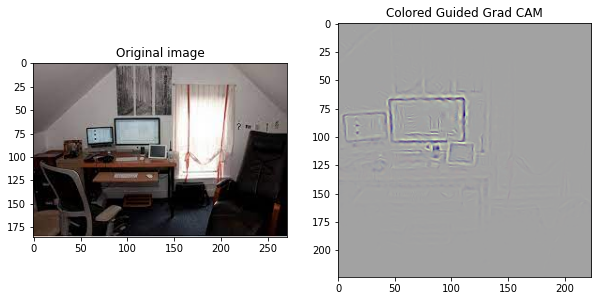

 -----------------  Guided GradCAM completed for image 3 ----------------------- 



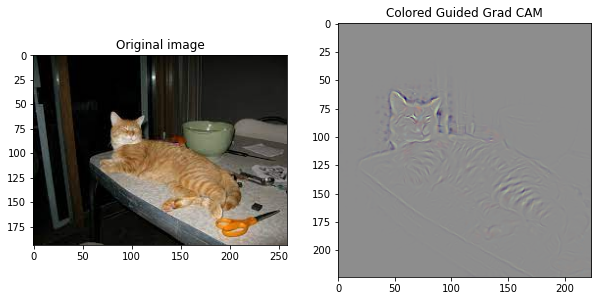

 -----------------  Guided GradCAM completed for image 4 ----------------------- 



In [39]:
n_examples = 5        
for index in range(n_examples):
    example_index = index           # Example[index]

    img_path = example_list[example_index][0]
    target_class = example_list[example_index][1]      # Target class for the image

    # Read and preprocess image
    original_image = Image.open(img_path).convert('RGB')
    prep_img = preprocess_image(original_image)         

    # Instantitate the GGCAM class
    GGCAM = Guided_Grad_CAM()
    GGCAM_output = GGCAM.get_guidedGradCAM(pretrained_model, prep_img, target_class)
    display_two_images(original_image, np.transpose(GGCAM_output, (1, 2, 0)),'Guided Grad CAM')
    print(f' -----------------  Guided GradCAM completed for image {index} ----------------------- \n')
    


## Question 2

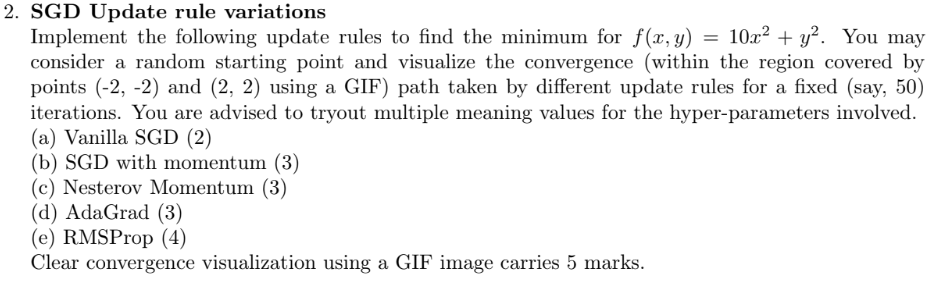

### Helper functions : -

In [14]:
from sympy import symbols, diff
import numpy as np
import matplotlib.pyplot as plt

def objective_fn(x, y):
    """ The objective function whose minima we are to find. """

    f = (10*x**2 + y**2)
    return f


def compute_gradient(f):
    """ A helper function to calculate the gradient of the objective function 
        Returns :
        Partial derivative of the obj_fn  w.r.t 'x' and 'y' respectively .
                                                                                 """
    x, y = symbols('x y')
    df_dx = diff(f, x)
    df_dy = diff(f, y)
    
    return df_dx, df_dy


def generate_random_xy(min_ = -2, max_ = 2):
    """ A helper function that generates random
    x and y coordinates between min_ and max_ .
                                                """
    
    x_rand , y_rand = np.random.rand(2)
    scaled_x =  min_ + x_rand *(max_ - min_)
    scaled_y =  min_ + y_rand *(max_ - min_)
    
    return scaled_x , scaled_y
        


## Defining GD Variants Functions

In [15]:
def VanillaGD(epochs, lr, x0, y0):
    
    x_value, y_value = x0, y0
    x_list , y_list = [], []
    x_list.append(x_value)
    y_list.append(y_value)
    
    x , y = symbols('x y')
    
    df_dx, df_dy = compute_gradient(objective_fn(x, y))
    
    for i in range(epochs):
        
        # Compute gradients at x = x_value and y = y_value
        dx = df_dx.subs([(x, x_value), (y, y_value)])
        dy = df_dy.subs([(x, x_value), (y, y_value)])
        
        # update rule
        x_value = x_value - lr*dx
        y_value = y_value - lr*dy 
        
        # Plotting purposes
        x_list.append(x_value)
        y_list.append(y_value)
        
    return x_list, y_list

def GD_with_momentum(epochs, lr, x0, y0, gamma = 0.3):
    
    x_value, y_value = x0, y0
    x_list , y_list = [], []
    x_list.append(x_value)
    y_list.append(y_value)
    
    prev_x, prev_y = 0, 0           # initialise the history component to 0
    
    x , y = symbols('x y')
    
    df_dx, df_dy = compute_gradient(objective_fn(x, y))
    
    for i in range(epochs):
        
        # Compute gradients at x = x_value and y = y_value
        dx = df_dx.subs([(x, x_value), (y, y_value)])
        dy = df_dy.subs([(x, x_value), (y, y_value)])
        
        # Exponential decaying cumulative average of previous gradients(prev_x) and current gradient(dx).
        update_x = gamma*prev_x + lr*dx             # change_x(t) = momentum * change_x(t-1) + step_size * f'(x(t-1))
        update_y = gamma*prev_y + lr*dy
        
        
        # Move with the new update rule
        x_value = x_value - update_x
        y_value = y_value - update_y 
        
        # Update the history component gradients
        prev_x = update_x
        prev_y = update_y        
        
        # Plotting purposes
        x_list.append(x_value)
        y_list.append(y_value)
    
    return x_list, y_list

def Nesterov_momentum(epochs, lr, x0, y0, gamma = 0.3):
    
    x_value, y_value = x0, y0
    x_list , y_list = [], []
    x_list.append(x_value)
    y_list.append(y_value)
    
    prev_x, prev_y = 0, 0           # initialise the history component to 0
    x_look_ahead, y_look_ahead = 0, 0
    
    #First Look Ahead Point
    x_look_ahead = x_value - gamma*prev_x                      #X_look_ahead = x_t - gamma*x_update_t-1
    y_look_ahead = y_value - gamma*prev_y                      #Y_look_ahead = y_t - gamma*y_update_t-1
    
    x , y = symbols('x y')
    df_dx, df_dy = compute_gradient(objective_fn(x, y))
    
    for i in range(epochs):
        
        # Compute gradients at x = x_look_ahead and y = y_look_ahead
        dx_look_ahead = df_dx.subs([(x, x_look_ahead), (y, y_look_ahead)])          
        dy_look_ahead = df_dy.subs([(x, x_look_ahead), (y, y_look_ahead)])
        
        # Exponential decaying cumulative average of previous gradients(prev_x) and current gradient(dx).
        update_x = gamma*prev_x + lr*dx_look_ahead               
        update_y = gamma*prev_y + lr*dy_look_ahead            # v_t = gamma*v_(t-1) + eta*grad(w_temp)
              
        # NAG update rule
        x_value = x_value - update_x
        y_value = y_value - update_y 
        
        # Update the history component gradients
        prev_x = update_x
        prev_y = update_y   
        
        # New Look Ahead point after parameter update           # w_temp = w_look_ahead
        x_look_ahead = x_value - gamma*prev_x                   # w_temp = w_t - gamma * v_(t-1)   
        y_look_ahead = y_value - gamma*prev_y
        
        # Plotting purposes
        x_list.append(x_value)
        y_list.append(y_value)
    
    return x_list, y_list

def AdaGrad(epochs, lr, x0, y0, epsilon = 1e-6):
    
    x_value, y_value = x0, y0
    x_list , y_list = [], []
    x_list.append(x_value)
    y_list.append(y_value)
    
    update_x, update_y = 0, 0
    x , y = symbols('x y')
    
    df_dx, df_dy = compute_gradient(objective_fn(x, y))
    
    for i in range(epochs):
        
        # Compute gradients at x = x_value and y = y_value
        dx = df_dx.subs([(x, x_value), (y, y_value)])
        dy = df_dy.subs([(x, x_value), (y, y_value)])
        
        # Value of v_t 
        update_x = update_x + dx**2         # v_t = v_(t-1) + grad(w_t)**2
        update_y = update_y + dy**2
        
        update_x = np.float32(update_x)
        update_y = np.float32(update_y)

        # Adagrad update rule using its own effective learning rate : Calculate new x and y position
        x_value = x_value - (lr/np.sqrt(update_x + epsilon))*dx   # dividing the learning with the history of gradient value until that point. 
        y_value = y_value - (lr/np.sqrt(update_y + epsilon))*dy   # Sparse features =>  very less gradient history value => large effective lr.
        
        # Plotting purposes
        x_list.append(x_value)
        y_list.append(y_value)
        
    return x_list, y_list
    
    


def RMSProp(epochs, lr, x0, y0, epsilon = 1e-6, beta = 0.95):
    
    x_value, y_value = x0, y0
    x_list , y_list = [], []
    x_list.append(x_value)
    y_list.append(y_value)
    
    update_x, update_y = 0, 0
    x , y = symbols('x y')
    
    df_dx, df_dy = compute_gradient(objective_fn(x, y))
    
    for i in range(epochs):
        
        # Compute gradients at x = x_value and y = y_value
        dx = df_dx.subs([(x, x_value), (y, y_value)])
        dy = df_dy.subs([(x, x_value), (y, y_value)])
        
        # Value of v_t : To prevent the denominator from growing rapidly, we decay it !
        update_x = beta * update_x + (1 - beta) * dx**2         # v_t = beta * v_(t-1) + (1- beta) * grad(w_t)**2
        update_y = beta * update_y + (1 - beta) * dy**2

        # Convert the sympy Float datatype to numpy float
        update_x = np.float32(update_x)
        update_y = np.float32(update_y)
     
        # RMSProp update rule using its own effective learning rate
        x_value = x_value - (lr/np.sqrt(update_x + epsilon))*dx   # dividing the learning with the history of gradient value until that point. 
        y_value = y_value - (lr/np.sqrt(update_y + epsilon))*dy   # Sparse features =>  very less gradient history value => large effective lr.
        
        # Plotting purposes
        x_list.append(x_value)
        y_list.append(y_value)
        
    return x_list, y_list
    

## Preparing data for the convergence visualisation in 2D

In [17]:
np.random.seed(4)
x0, y0 = generate_random_xy()     
list_of_x_lists = []
list_of_y_lists = []
gd_lists = [key for key in gd_variant]
epochs = 500
steps = 5

for key in gd_variant:                   # loop through different GD algorithms
    x0, y0 = generate_random_xy()        # Start from different initial points
    lr = 0.01
    if key == 'Adagrad':                    # AdaGrad is generally very slow, so needs higher learning rate comparatively
        lr = 0.05
        
    x_list, y_list = gd_variant[key](epochs, lr, x0, y0)
    print(key, lr)
    list_of_x_lists.append(x_list)
    list_of_y_lists.append(y_list) 


Vanilla GD 0.01
GD with momentum 0.01
Nesterov Momentum 0.01
Adagrad 0.05
RMS propogation 0.01


## Simultaneous Convergence Visualisation in 2D 

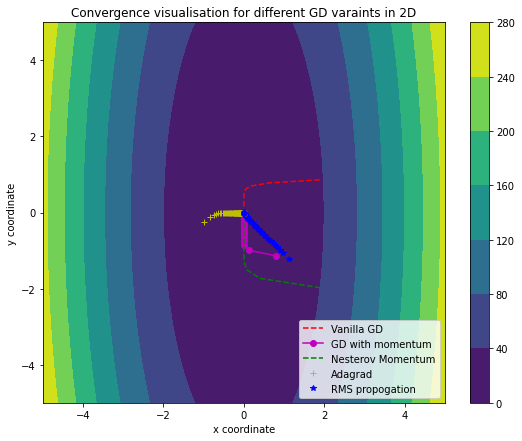

In [18]:
def convergence_plot2D(list_of_x_lists, list_of_y_lists, steps):
    
    fig, ax = plt.subplots(1, 1, figsize=(9, 7))
    
    # Create empty lines for each GD variant with different markers and colors
    l1, = plt.plot([], [], 'r--')
    l2, = plt.plot([], [], 'mo-')
    l3, = plt.plot([], [], 'g--')
    l4, = plt.plot([], [], 'y+')
    l5, = plt.plot([], [], 'b*')
    
    # Create empty points for each GD variant
    p1, = plt.plot([], [], 'ro')
    p2, = plt.plot([], [], 'mo')
    p3, = plt.plot([], [], 'go')
    p4, = plt.plot([], [], 'yo')
    p5, = plt.plot([], [], 'bo')

    plt.legend(gd_lists, loc="lower right")
    plt.xlabel('x coordinate')
    plt.ylabel('y coordinate')
    plt.title('Convergence visualisation for different GD varaints in 2D')
    plt.xlim(-5, 5)
    plt.ylim(-5, 5)
    
    feature_x = np.linspace(-5.0, 5.0, 50)
    feature_y = np.linspace(-5.0, 5.0, 50)
    
    # Creating 2-D grid of features
    [X, Y] = np.meshgrid(feature_x, feature_y)
    Z = 10*X ** 2 + Y ** 2

    # plots filled contour plot
    cp = ax.contourf(X, Y, Z)
    fig.colorbar(cp)

    xlist1, xlist2, xlist3, xlist4, xlist5 = [], [], [], [], []
    ylist1, ylist2, ylist3, ylist4, ylist5 = [], [], [], [], []
    
    metadata = dict(title='Movie', artist='Donal')
    writer = PillowWriter(fps=10, metadata=metadata)
    with writer.saving(fig, "simultaneous_conv_visual.gif", 100):
        
        for i in range(0, len(list_of_x_lists[0]), steps):
            xlist1.append(list_of_x_lists[0][i])
            xlist2.append(list_of_x_lists[1][i])
            xlist3.append(list_of_x_lists[2][i])
            xlist4.append(list_of_x_lists[3][i])
            xlist5.append(list_of_x_lists[4][i])

            ylist1.append(list_of_y_lists[0][i])
            ylist2.append(list_of_y_lists[1][i])
            ylist3.append(list_of_y_lists[2][i])
            ylist4.append(list_of_y_lists[3][i])
            ylist5.append(list_of_y_lists[4][i])

            l1.set_data(xlist1,ylist1)             # line 1 will be rendered
            l2.set_data(xlist2,ylist2)          # line 2 will be rendered simultanwously
            l3.set_data(xlist3,ylist3)             # line 1 will be rendered
            l4.set_data(xlist4,ylist4)          # line 2 will be rendered simultanwously        
            l5.set_data(xlist5,ylist5)             # line 1 will be rendered

            j = i//steps
            p1.set_data(xlist1[j], ylist1[j])
            p2.set_data(xlist2[j], ylist2[j])
            p3.set_data(xlist3[j], ylist3[j])
            p4.set_data(xlist4[j], ylist4[j])
            p5.set_data(xlist5[j], ylist5[j])

            writer.grab_frame()

# Call the function with appropriate arguments           
convergence_plot2D(list_of_x_lists, list_of_y_lists, steps)

## Plot function for Convergence Visualisation in 3D

MovieWriter PillowWriter unavailable; using Pillow instead.
MovieWriter PillowWriter unavailable; using Pillow instead.
MovieWriter PillowWriter unavailable; using Pillow instead.
MovieWriter PillowWriter unavailable; using Pillow instead.
MovieWriter PillowWriter unavailable; using Pillow instead.


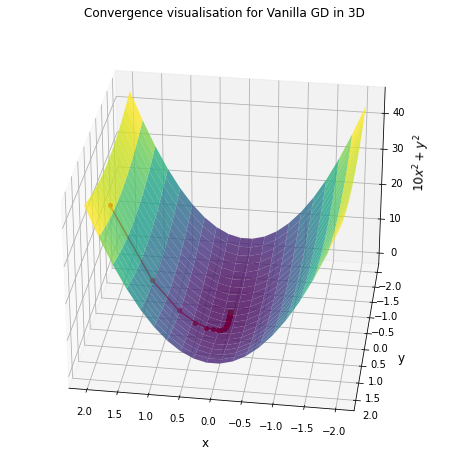

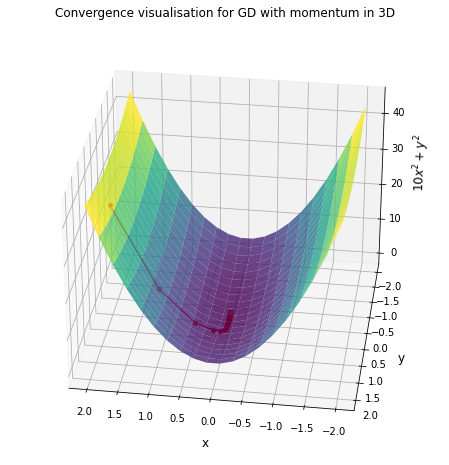

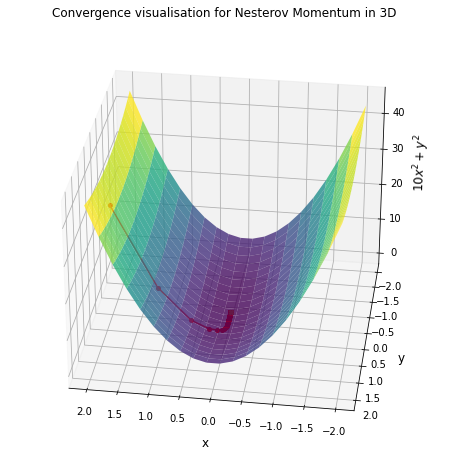

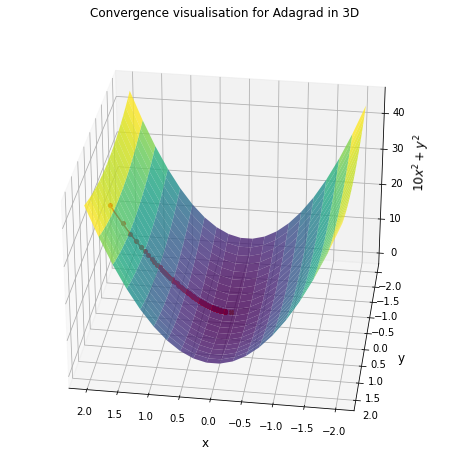

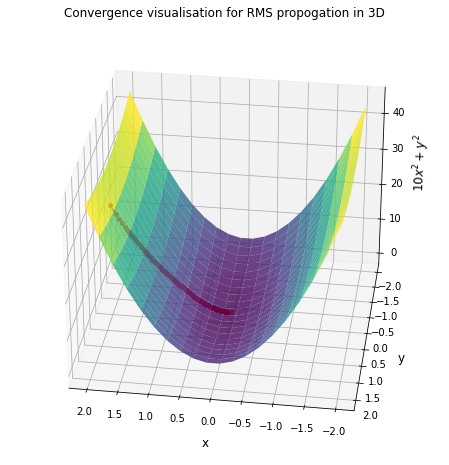

In [43]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation
from matplotlib.animation import PillowWriter


def gen(x_list, y_list, step):
    """ The function generates a sequence of points given the x and y coordinate lists 
        and step size. 
        Yields : an array of three values, the x, y, and  = objective_fn(x,y).
                                                                                """
    for i in range(0, len(x_list), step):      
        yield np.array([x_list[i], y_list[i], objective_fn(x_list[i], y_list[i])])
  
    
    
def update(num, data, line):          # data is the 3 x (num + 1) array        # Here, num = 100
    """ The function updates the data points on the plot during the animation.
        Args:
            num: frame number
            data : the data points
            line: the plot line
            """
    line.set_data(data[:2, :num])           # [:2, :101]  => x, y coordiantes of all points
    line.set_3d_properties(data[2, :num])    # [2, :101]  => corresponding z values

    
    
def plot_and_save_GIF(x_list, y_list, objective_fn, gd_variant_name, step):  
    """ Generates and saves the GIF for a given GD algorithm variant by its name.
                                                                                    """
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(projection='3d')
    epochs = len(x_list)
    N = epochs//step                    # integer division
    
    # Defining Range of x and y
    x_range = np.linspace(-2,2,20)
    y_range = np.linspace(-2,2,20)
    
    # Plot the region f(x,y)
    xx, yy = np.meshgrid(x_range, y_range)
    fn_value_mesh = objective_fn(xx, yy)
    ax.plot_surface(xx, yy, fn_value_mesh, cmap='viridis', alpha=0.8)

    
    # Mark the minima  in the region f(x, y)
    ax.scatter(0, 0, 0, c='#E67A0D', marker='X')
    
    # Set x y, z axis labels
    ax.set_xlabel('x', fontsize=12, labelpad=8); ax.set_ylabel('y', fontsize=12, labelpad=8) 
    ax.set_zlabel(r'$10x^2 + y^2$', rotation = 0, fontsize=12, labelpad=10)
    ax.view_init(30, 98)

    # DATA for plotting the path taken by the gd algo
    data = np.array(list(gen(x_list, y_list, step))).T                          # data is a 3 x 51 array    
    line, = ax.plot(data[0, 0:1], data[1, 0:1], data[2, 0:1], c="red", marker=".", markersize=8)
    
    # Save the gif as gif
    ani = animation.FuncAnimation(fig, update, N, fargs=(data, line), interval=20000/N, blit=False)   # fig, update, fargs=(data, line)
    ani.save(f'{gd_variant_name}.gif', writer='PillowWriter')
    plt.title(f'Convergence visualisation for {gd_variant_name} in 3D')
    
    

# Defining the dictionary storing different GD variants 
gd_variant = {'Vanilla GD': VanillaGD, 'GD with momentum': GD_with_momentum, 
              'Nesterov Momentum' : Nesterov_momentum, 'Adagrad': AdaGrad, 'RMS propogation': RMSProp }



# Generate a random starting point(same for each of the GD variants)
np.random.seed(24)
x0, y0 = generate_random_xy()      


# loop through different GD algorithms
for key in gd_variant:   
    epochs = 250
    lr = 0.01
    step = 2 
    if key == 'Adagrad':               # Adagrad is geneally a lot slower than other GD algos, hence higher learning rate
        lr = 0.1
        
    x_list, y_list = gd_variant[key](epochs, lr, x0, y0)
    plot_and_save_GIF(x_list, y_list, objective_fn, key, step)
    
